# Downstream analysis and plotting

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc

data_type = 'float32'

# this line forces theano to use the GPU and should go before importing cell2location
#os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# if using the CPU uncomment this:
#os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Loading Visium data <a name="1.-Loading-Visium-data"></a>


In [2]:
# Set paths to data and results used through the document:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/Visium/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/gut/'

regression_model_output = 'RegressionGeneBackgroundCoverageGeneTechnologyTorch_88covariates_124049cells_13904genes_noLN_revise'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

Now, let's read the spatial Visium data with cell2location output

In [3]:
def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide


### Read saved sklearn colocated cell group model <a class="anchor" id="read_nmf"></a>

In [9]:
sp_data_path = f'{results_folder}LocationModelLinearDependentWMultiExperiment_3experiments_65clusters_4645locations_13904genes_F78_63_revised_2nd_trimester/'

n_fact = 17
mod_path = f'{sp_data_path}CoLocatedComb_tol_0001/CoLocatedGroupsSklearnNMF_4645locations_65factors/models/' 
adata_file = f'{sp_data_path}CoLocatedComb_tol_0001/CoLocatedGroupsSklearnNMF_4645locations_65factors/anndata/sp.h5ad' 

def unpickle_model(path, mod_name):
    r""" Unpickle model
    """
    import pickle
    file = path + 'model_' + mod_name + ".p"
    
    mod1_ann = pickle.load(file = open(file, "rb"))
    return mod1_ann['mod']
mod_sk = unpickle_model(mod_path, f'n_fact{n_fact}')

adata_vis_sk = anndata.read(adata_file)

# path for saving figures
fig_path = f'{sp_data_path}plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

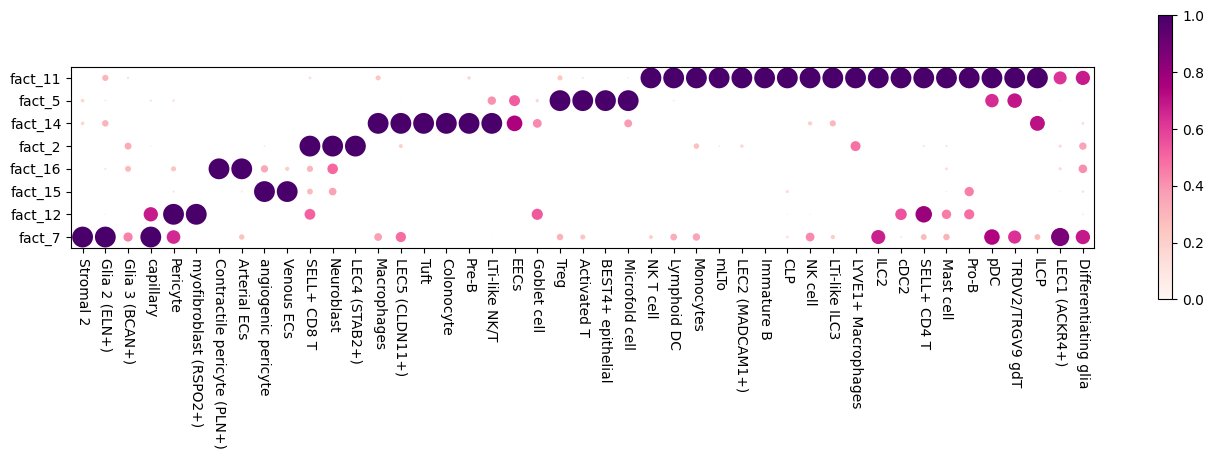

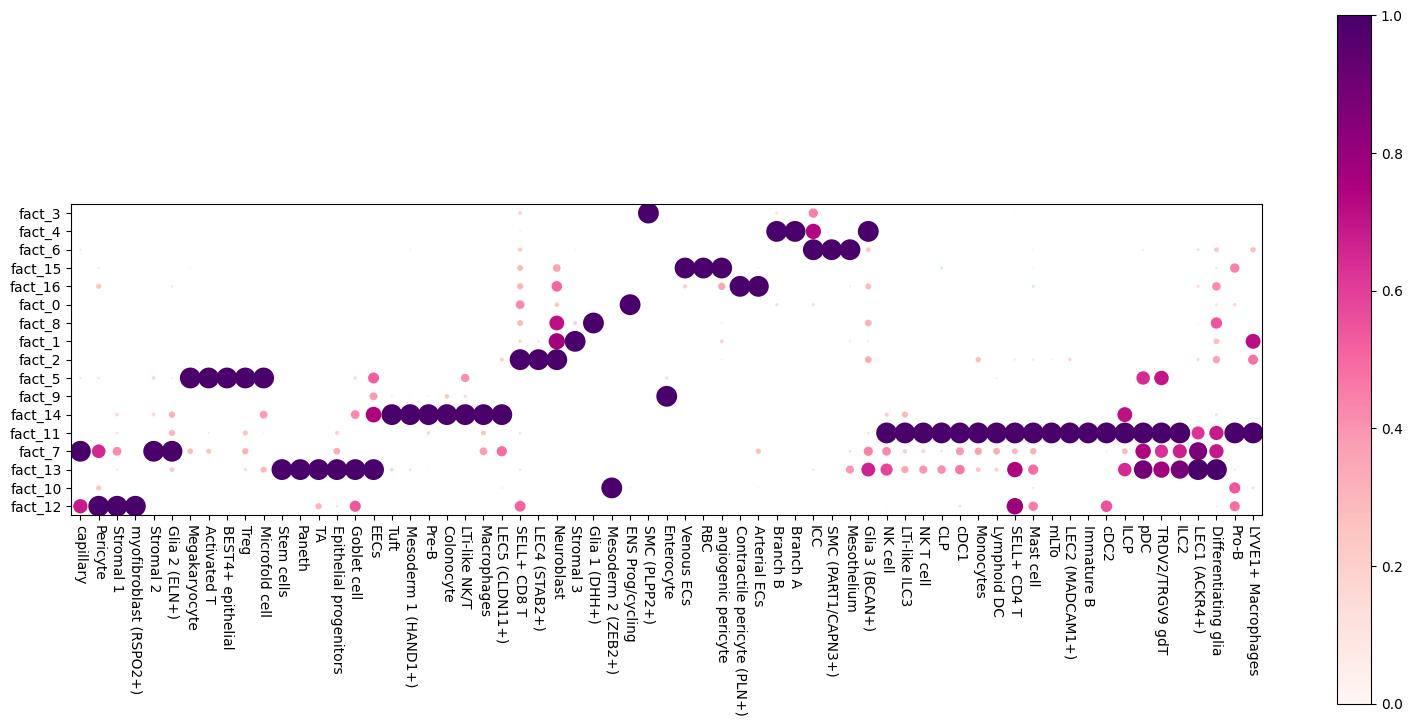

In [48]:
ct_sel = ['RBC', 'Megakaryocyte', 'Mesoderm 1 (HAND1+)',
          'Stromal 1', 'cDC1', 'Epithelial progenitors'
            ]

fact_filt = ['fact_11', 'fact_5', 'fact_14', 'fact_2', # lymphoid
             'fact_16', 'fact_15', 'fact_12', 'fact_7', # blood vessels
             #'fact_6', 'fact_3', # SMC
             #'fact_4', 'fact_8' # glia
            ] 

mod_sk.cell_type_fractions = (mod_sk.cell_type_fractions.T / mod_sk.cell_type_fractions.max(1)).T

from cell2location.plt.plot_heatmap import clustermap
mpl.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
ct_index = (mod_sk.cell_type_fractions.loc[:, fact_filt].sum(1) > 0.5) \
& ~ mod_sk.cell_type_fractions.index.isin(ct_sel)
clustermap(mod_sk.cell_type_fractions.loc[ct_index,
                                          fact_filt].T,
           cluster_rows=False, cluster_cols=True, 
           cmap='RdPu',
           figure_size=[5.9 + 0.12 * mod_sk.n_var, 3.5 + 0.1 * len(fact_filt)],
           fun_type='dotplot', array_size=None)

plt.savefig(f'{fig_path}/Fig5_spatial_fact_dotplot.pdf', bbox_inches='tight')
plt.show()

clustermap(mod_sk.cell_type_fractions.T,
           cluster_rows=True, cluster_cols=True, 
           cmap='RdPu',
           figure_size=[8 + 0.12 * mod_sk.n_var, 5.9 + 0.1 * mod_sk.n_fact],
           fun_type='dotplot', array_size=None)

plt.savefig(f'{fig_path}/Fig5_spatial_fact_dotplot_all_suppl.pdf', bbox_inches='tight')
plt.show()

In [47]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/gut/LocationModelLinearDependentWMultiExperiment_3experiments_65clusters_4645locations_13904genes_F78_63_revised_2nd_trimester/plots/figures/'

In [43]:
help(clustermap)

Help on function clustermap in module cell2location.plt.plot_heatmap:

clustermap(df, cluster_rows=True, cluster_cols=True, figure_size=(5, 5), cmap='RdPu', log=False, return_linkage=False, equal=True, title='', fun_type='heatmap', array_size=None, vmin=None, vmax=None)
    Plot heatmap with hierarchically clustered rows and columns using `cell2location.plt.plot_heatmap.heatmap()`
    and `cell2location.plt.plot_heatmap.dotplot()`.
    
    :param df: pandas.DataFrame to be visualised using heatmap and dotplot
    :param cluster_rows: cluster rows or keep the same order as df?
    :param cluster_cols: cluster columns or keep the same order as df?
    :param figure_size: tuple specifying figure dimensions, passed to .heatmap
    :param cmap: pyplot colormap, passed to .heatmap
    :param log: boolean, color on logscale?
    :param return_linkage: return the plot or the plot + linkage for rows and columns? If true returns a dictionary with 'plot', 'row_linkage' and 'col_linkage' elements

Modules and their versions used for this analysis

In [19]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.18.1
IPython.core.release 7.18.1
logging 0.5.1.2
zlib 1.0
traitlets 5.0.4
traitlets._version 5.0.4
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.18.1
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.7
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.3
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
tornado 6.0.4
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 